In [3]:
import numpy as np
import pandas as pd

from scipy.stats.distributions import poisson
from matplotlib import pyplot as plt

import pymc3 as pm

# Poisson distribution

The probability mass fuction (PMF) is
$$
P(k\mathrm{~events~in~interval}) = \frac{\lambda^k}{k!}e^{-\lambda}
$$

Let's say that some river floods, on average, once every year.  What is the probability of the river flooding three times in the same year?

In [4]:
rv = poisson(1) # average rate is 1/unit time (e.g., year)

Probability of 3 events in one year is 0.061


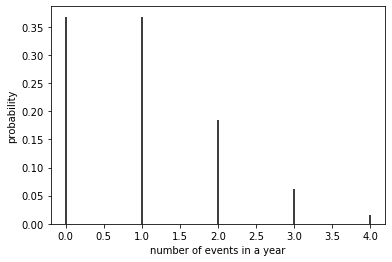

In [5]:
nevents = np.arange(5)
target_num = 3

plt.vlines(nevents, 0, rv.pmf(nevents))
plt.xlabel("number of events in a year")
plt.ylabel("probability")
plt.ylim(ymin=0)

print("Probability of {} events in one year is {:.3f}".format(target_num, rv.pmf(target_num)))

## Coal Mining Disasters

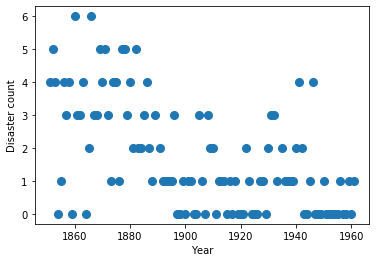

In [6]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [7]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/opt/conda/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [8]:
with disaster_model:
    trace = pm.sample(10000, chains=4, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:02<00:00, 670.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


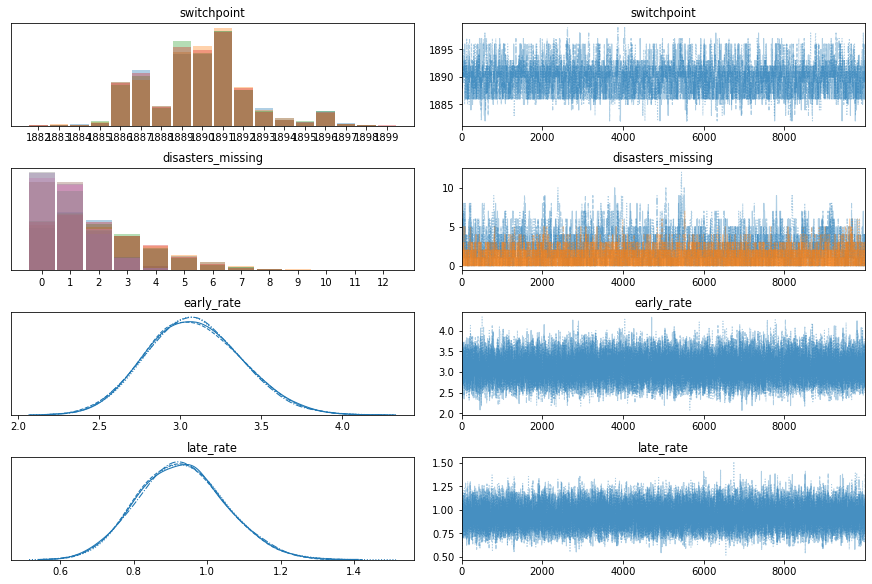

In [9]:
pm.traceplot(trace);

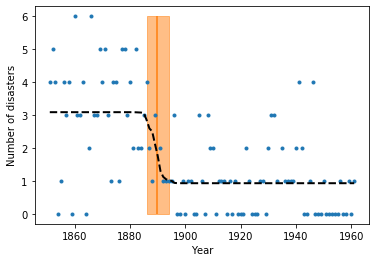

In [10]:
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of disasters")
plt.xlabel("Year")

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

# Hurricanes

In [11]:
!pip install --quiet lxml bs4

In [12]:
pd.read_html('http://www.stormfax.com/huryear.htm')

[                    0             1           2                3   4
 0                Year  Named Storms  Hurricanes  MajorHurricanes NaN
 1                1851             6           3                1 NaN
 2                1852             5           5                1 NaN
 3                1853             8           4                2 NaN
 4                1854             5           3                1 NaN
 ..                ...           ...         ...              ...  ..
 165              2015            11           4                2 NaN
 166              2016            15           7                4 NaN
 167              2017            17          10                6 NaN
 168               NaN           NaN         NaN              NaN NaN
 169  Average1981-2010            12         6.5                2 NaN
 
 [170 rows x 5 columns]]

In [13]:
pd.read_html('http://www.stormfax.com/huryear.htm', header=0)

[                 Year  Named Storms  Hurricanes  MajorHurricanes  Unnamed: 4
 0                1851           6.0         3.0              1.0         NaN
 1                1852           5.0         5.0              1.0         NaN
 2                1853           8.0         4.0              2.0         NaN
 3                1854           5.0         3.0              1.0         NaN
 4                1855           5.0         4.0              1.0         NaN
 ..                ...           ...         ...              ...         ...
 164              2015          11.0         4.0              2.0         NaN
 165              2016          15.0         7.0              4.0         NaN
 166              2017          17.0        10.0              6.0         NaN
 167               NaN           NaN         NaN              NaN         NaN
 168  Average1981-2010          12.0         6.5              2.0         NaN
 
 [169 rows x 5 columns]]

In [14]:
data = pd.read_html('http://www.stormfax.com/huryear.htm', header=0)[0][:-2]
data

,Year,Named Storms,Hurricanes,MajorHurricanes,Unnamed: 4
0,1851,6.0,3.0,1.0,NaN
1,1852,5.0,5.0,1.0,NaN
2,1853,8.0,4.0,2.0,NaN
3,1854,5.0,3.0,1.0,NaN
4,1855,5.0,4.0,1.0,NaN
...,...,...,...,...,...
162,2013,14.0,2.0,0.0,NaN
163,2014,8.0,6.0,2.0,NaN
164,2015,11.0,4.0,2.0,NaN
165,2016,15.0,7.0,4.0,NaN


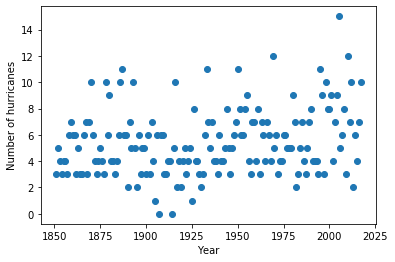

In [15]:
years = data['Year'].astype('int')
nhurricanes = data['Hurricanes']


plt.scatter(years, nhurricanes)
plt.xlabel('Year')
plt.ylabel('Number of hurricanes');

In [16]:
with pm.Model() as model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1950)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', .1)
    late_rate = pm.Exponential('late_rate', .1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    hurricanes = pm.Poisson('hurricanes', rate, observed=[nhurricanes])

In [17]:
with model:
    trace = pm.sample(1000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:02<00:00, 503.41it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


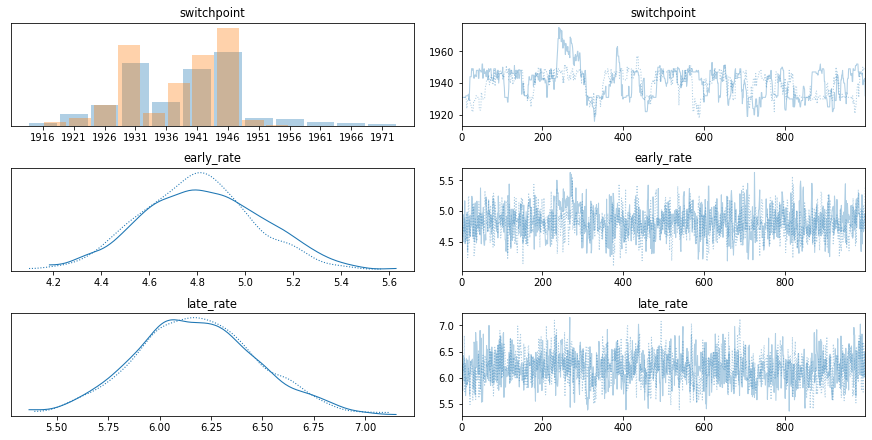

In [18]:
pm.traceplot(trace);

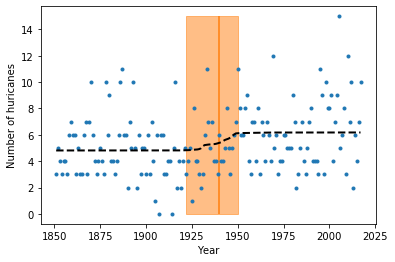

In [19]:
plt.plot(years, nhurricanes, '.')
plt.ylabel("Number of huricanes")
plt.xlabel("Year")

plt.vlines(trace['switchpoint'].mean(), nhurricanes.min(), nhurricanes.max(), color='C1')
average_hurricanes = np.zeros_like(nhurricanes, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_hurricanes[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[nhurricanes.min(), nhurricanes.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_hurricanes,  'k--', lw=2);

In [20]:
average_hurricanes

array([4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81458882, 4.81458882, 4.81458882, 4.81458882, 4.81458882,
       4.81525584, 4.81525584, 4.81563779, 4.81961006, 4.82381569,
       4.8260569 , 4.83278237, 4.83685257, 4.84430085, 4.86157